## Import des packages

- tqdm : barre de progression
- pathlib : gestion des chemins de fichiers
- librosa : traitement audio
- os : gestion des fichiers
- torch : PyTorch
- numpy : calculs numériques
- soundfile : lecture/écriture de fichiers audio
- s3prl : framework d'extraction de features audio
- sklearn : outils de machine learning

In [1]:
import math
from pathlib import Path

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.optim import AdamW
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import TensorDataset, DataLoader

## Paramètres globaux

- random_seed : graine aléatoire pour reproductibilité
- device : choix du device (GPU si disponible, sinon CPU)
- embedding_path : chemin vers le dossier de sauvegarde des embeddings extraits
- saved_model_path : chemin vers les sauvegardes des modeles

In [2]:
random_seed = 42
limit = 200

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)

embedding_path = Path("./16k_Hz_embedding/")
pooled_path = Path("./16k_Hz_pooled/")

# Pooled versions paths
pooled_mean_path = pooled_path / "mean"
pooled_max_path = pooled_path / "max"
pooled_mean_std_path = pooled_path / "mean_std"

train_mean_path = pooled_mean_path / "_train.pt"
val_mean_path = pooled_mean_path / "_val.pt"
test_mean_path = pooled_mean_path / "_test.pt"

train_max_path = pooled_max_path / "_train.pt"
val_max_path = pooled_max_path / "_val.pt"
test_max_path = pooled_max_path / "_test.pt"

train_mean_std_path = pooled_mean_std_path / "_train.pt"
val_mean_std_path = pooled_mean_std_path / "_val.pt"
test_mean_std_path = pooled_mean_std_path / "_test.pt"

saved_MLP_model_path = "./saved_MLP.pth"

# Not pooled versions paths
transformer_path = embedding_path / "transformer"

train_transformer_path = transformer_path / "_train.pt"
val_transformer_path = transformer_path / "_val.pt"
test_transformer_path = transformer_path / "_test.pt"

saved_transformer_model_path = "./saved_transformer.pth"

AUDIO_EXTENSIONS = (".wav", ".mp3", ".flac", ".ogg", ".m4a")

Device: cpu


## Fonctions utilitaires pour associer les fichiers audio à leurs émotions
- find_emotion_T : fonction pour la base TESS
- emotionfix : fonction pour ajuster les indices d'émotions pour la classification

In [3]:
# Emotion kind validation function for TESS database, due to emotions written within the file names.
def find_emotion_T(name):
    if 'neutral' in name:
        return "01"
    elif 'happy' in name:
        return "03"
    elif 'sad' in name:
        return "04"
    elif 'angry' in name:
        return "05"
    elif 'fear' in name:
        return "06"
    elif 'disgust' in name:
        return "07"
    elif 'ps' in name:
        return "08"
    else:
        return "-1"


# 'emotions' list fix for classification purposes:
#     Classification values start from 0, Thus an 'n = n-1' operation has been executed for both RAVDESS and TESS databases:
def emotionfix(e_num):
    if e_num == "01":
        return 0  # neutral
    elif e_num == "02":
        return 1  # calm
    elif e_num == "03":
        return 2  # happy
    elif e_num == "04":
        return 3  # sad
    elif e_num == "05":
        return 4  # angry
    elif e_num == "06":
        return 5  # fear
    elif e_num == "07":
        return 6  # disgust
    else:
        return 7  # suprised

labels = [0,1,2,3,4,5,6,7]

## Chargement des differents sets pour la methode de pooling renseignée et association des enregistrements à leur label

In [4]:
def load_split(file_list, base_path, is_transformer=False):
    embeddings, labels = [], []

    for file_name in file_list:

        if not file_name.startswith("_") and file_name.endswith(".pt"):

            # 1) Charge l'embedding
            emb = torch.load(base_path / file_name)  # tensor

            # 2) Détecte l'émotion
            emo_code = find_emotion_T(file_name)
            if emo_code == "-1":
                emo_code = file_name[6:8]  # RAVDESS
            label = emotionfix(emo_code)

            print(f"file_name : {file_name}, label : {label}")
            embeddings.append(emb)
            labels.append(label)
    if is_transformer:
        X = pad_sequence(embeddings, batch_first=True)
    else:
        X = torch.stack(embeddings)
    y = torch.tensor(labels)
    return X, y


## Classifier MLP

In [5]:
# -------------------------
# 1) MLP Classifier
# -------------------------
class MLPClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        return self.net(x)

    def save(self, path):
        torch.save(self.net.state_dict(), path)

    def load(self, path):
        self.net.load_state_dict(torch.load(path))

## Classifier Transformer

In [6]:
# -------------------------
# 2) Transformer léger (sequence-based)
# -------------------------
# Ici on suppose que X_train est (N, seq_len, hidden_dim) càd embeddings NON poolés (mean/max/mean_std)
# Pour transformer, il faut des embeddings frame-level.

# -------------------------
# Dataset et DataLoader pour Transformer avec mask
# -------------------------
class PadDataset(torch.utils.data.Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


# --- collate fn: explicit pad_value and mask generation ---
PAD_VALUE = 0.0   # use 0.0 padding (consistent with mask logic)

def collate_fn(batch, pad_value=PAD_VALUE):
    X_batch, y_batch = zip(*batch)                     # each X is (seq_len_i, dim)
    # pad_sequence expects list of tensors (seq_len, dim) -> returns (batch, max_seq_len, dim)
    X_batch = pad_sequence(X_batch, batch_first=True, padding_value=pad_value)
    y_batch = torch.tensor(y_batch, dtype=torch.long)

    # Mask: True for real tokens (non-padding)
    # Use norm instead of abs.sum for clarity
    mask = (X_batch.norm(dim=2) != pad_value)   # True = token real if pad_value is 0.0
    return X_batch, y_batch, mask

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=1000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:, :x.size(1)]
        return x


# --- Improved TransformerClassifier: projection -> smaller d_model, LN, dropout, classifier head ---
class TransformerClassifier(nn.Module):
    def __init__(self, input_dim, num_classes, d_model=256, n_layers=2, n_heads=8, dropout=0.1, ff_dim=512):
        super().__init__()
        # project input embeddings down to smaller d_model
        self.input_proj = nn.Linear(input_dim, d_model)
        self.pos_encoding = PositionalEncoding(d_model, max_len=1200)  # safe margin
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=n_heads,
            dim_feedforward=ff_dim,
            dropout=dropout,
            batch_first=True
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=n_layers)
        self.cls_token = nn.Parameter(torch.randn(1, 1, d_model))
        self.layernorm = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)
        # small classifier head
        self.fc = nn.Sequential(
            nn.Linear(d_model, d_model // 2),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout),
            nn.Linear(d_model // 2, num_classes)
        )

    def forward(self, x, mask=None):
        # x: (B, S, input_dim)
        b = x.size(0)
        x = self.input_proj(x)   # (B, S, d_model)

        cls_tokens = self.cls_token.expand(b, -1, -1)   # (B,1,d_model)
        x = torch.cat((cls_tokens, x), dim=1)           # (B, S+1, d_model)
        x = self.pos_encoding(x)
        x = self.layernorm(x)

        if mask is not None:
            # mask: (B, S): True for real tokens (no cls). Need cls_mask True for cls token.
            cls_mask = torch.ones((b, 1), dtype=torch.bool, device=x.device)
            mask = torch.cat((cls_mask, mask), dim=1)   # (B, S+1)
            src_key_padding_mask = ~mask   # True = padding positions to be ignored
            x = self.encoder(x, src_key_padding_mask=src_key_padding_mask)
        else:
            x = self.encoder(x)

        cls_out = x[:, 0, :]                 # (B, d_model)
        cls_out = self.dropout(cls_out)
        return self.fc(cls_out)

    def save(self, path):
        torch.save(self.state_dict(), path)

    def load(self, path):
        self.load_state_dict(torch.load(path))

## Entrainement

In [7]:
# -------------------------
# Fonction d'entraînement
# -------------------------
def train_model(model, train_loader, val_loader, have_mask=False, model_name='MLP', num_epochs=20, lr=1e-4, weight_decay=1e-5):
    train_losses = []
    val_accuracies = []
    model.to(device)
    optimizer = AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    criterion = nn.CrossEntropyLoss()
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=2)


    for epoch in range(num_epochs):
        model.train()
        total_loss = 0.0
        correct = 0
        total = 0

        if have_mask :
            for X_batch, y_batch, mask in train_loader:
                X_batch = X_batch.to(device)
                y_batch = y_batch.to(device)
                mask = mask.to(device)

                optimizer.zero_grad()
                logits = model(X_batch, mask)
                loss = criterion(logits, y_batch)
                loss.backward()
                # gradient clipping
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                optimizer.step()

                total_loss += loss.item() * y_batch.size(0)
                preds = logits.argmax(dim=1)
                correct += (preds == y_batch).sum().item()
                total += y_batch.size(0)
        else :
            for X_batch, y_batch in train_loader:
                X_batch = X_batch.to(device)
                y_batch = y_batch.to(device)

                optimizer.zero_grad()
                logits = model(X_batch)
                loss = criterion(logits, y_batch)
                loss.backward()
                # gradient clipping
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                optimizer.step()

                total_loss += loss.item() * y_batch.size(0)
                preds = logits.argmax(dim=1)
                correct += (preds == y_batch).sum().item()
                total += y_batch.size(0)

        train_loss = total_loss / total
        train_acc = correct / total
        if model_name == 'transformer' :
            val_acc, p, yb = evaluate_transformer(model, val_loader)
        else :
            val_acc, p, yb = evaluate_MLP(model, val_loader)
        scheduler.step(val_acc)

        train_losses.append(train_loss)
        val_accuracies.append(val_acc)

        print(
            f"[{model_name.upper()}] Epoch {epoch+1}/{num_epochs} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.3f} | Val Acc: {val_acc:.3f}")

    # --- Plot Loss ---
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(1, num_epochs + 1), train_losses, marker='o', label='Train Loss')
    plt.title("Loss curve")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.grid(True)
    plt.legend()

    # --- Plot Accuracy ---
    plt.subplot(1, 2, 2)
    plt.plot(range(1, num_epochs + 1), val_accuracies, marker='o', color='orange', label='Val Accuracy')
    plt.title("Validation Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.grid(True)
    plt.legend()

    plt.show()

    return train_losses, val_accuracies

## Evaluation (MLP)

In [8]:
def evaluate_MLP(model, loader):
    model.eval()
    correct, total = 0, 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for X_batch, y_batch in loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            preds = model(X_batch).argmax(dim=1)

            # ACCUMULATION
            all_preds.append(preds.cpu())
            all_labels.append(y_batch.cpu())

            correct += (preds == y_batch).sum().item()
            total += y_batch.size(0)
    # CONCATENATE EVERYTHING
    all_preds = torch.cat(all_preds)
    all_labels = torch.cat(all_labels)

    return correct / total, all_preds, all_labels

## Evaluation (Transformer)

In [9]:
def evaluate_transformer(model, data_loader):
    model.eval()
    correct, total = 0, 0
    all_preds, all_labels = [], []
    with torch.no_grad():
        for X_batch, y_batch, mask in data_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            mask = mask.to(device)
            logits = model(X_batch, mask)
            preds = logits.argmax(dim=1)

            # ACCUMULATION
            all_preds.append(preds.cpu())
            all_labels.append(y_batch.cpu())

            correct += (preds == y_batch).sum().item()
            total += y_batch.size(0)

    # CONCATENATE EVERYTHING
    all_preds = torch.cat(all_preds)
    all_labels = torch.cat(all_labels)

    return correct / total if total > 0 else 0.0, all_preds, all_labels

## Division du dataset en Train Validation Test sets

In [10]:
paths = {
    "mean": [train_mean_path, val_mean_path, test_mean_path],
    "max": [train_max_path, val_max_path, test_max_path],
    "mean_std": [train_mean_std_path, val_mean_std_path, test_mean_std_path],
    "transformer": [train_transformer_path, val_transformer_path, test_transformer_path]
}

pooling_type = "mean"  # "max", "mean_std", "transformer"
batch_size = 16
num_classes = 8

## Chargement des differents sets pour la methode de pooling renseignée et association des enregistrements à leur label

In [11]:
train_path, val_path, test_path = paths[pooling_type]

train_files = torch.load(train_path)
val_files = torch.load(val_path)
test_files = torch.load(test_path)

X_train, y_train = load_split(train_files, pooled_mean_path)
X_val, y_val = load_split(val_files, pooled_mean_path)
X_test, y_test = load_split(test_files, pooled_mean_path)

file_name : OAF_peg_ps.pt, label : 7
file_name : YAF_lid_happy.pt, label : 2
file_name : YAF_perch_neutral.pt, label : 0
file_name : 03-01-07-02-02-01-18.pt, label : 6
file_name : YAF_door_neutral.pt, label : 0
file_name : OAF_wife_sad.pt, label : 3
file_name : OAF_note_disgust.pt, label : 6
file_name : YAF_calm_sad.pt, label : 3
file_name : 03-01-01-01-01-02-23.pt, label : 0
file_name : YAF_back_happy.pt, label : 2
file_name : 03-01-05-01-01-02-03.pt, label : 4
file_name : 03-01-06-01-02-02-04.pt, label : 5
file_name : 03-01-01-01-01-01-09.pt, label : 0
file_name : OAF_life_ps.pt, label : 7
file_name : OAF_soup_happy.pt, label : 2
file_name : 03-01-05-02-01-01-07.pt, label : 4
file_name : OAF_yes_happy.pt, label : 2
file_name : 03-01-01-01-02-01-12.pt, label : 0
file_name : 03-01-03-02-01-02-22.pt, label : 2
file_name : YAF_dime_happy.pt, label : 2
file_name : 03-01-02-01-02-02-02.pt, label : 1
file_name : 03-01-06-01-02-02-19.pt, label : 5
file_name : OAF_tool_disgust.pt, label : 6
f

## Verification des dimentions des differents sets

In [12]:
print(f"[MLP] Loaded splits:")
print("Train :", X_train.shape, y_train.shape)
print("Val   :", X_val.shape, y_val.shape)
print("Test  :", X_test.shape, y_test.shape)

MLP_train_dataset = TensorDataset(X_train, y_train)
MLP_val_dataset = TensorDataset(X_val, y_val)
MLP_test_dataset = TensorDataset(X_test, y_test)

MLP_train_loader = DataLoader(MLP_train_dataset, batch_size=batch_size, shuffle=True)
MLP_val_loader = DataLoader(MLP_val_dataset, batch_size=batch_size)
MLP_test_loader = DataLoader(MLP_test_dataset, batch_size=batch_size)

[MLP] Loaded splits:
Train : torch.Size([2967, 1024]) torch.Size([2967])
Val   : torch.Size([636, 1024]) torch.Size([636])
Test  : torch.Size([637, 1024]) torch.Size([637])


## Creation du MLP

In [13]:
input_dim = X_test.shape[1]
mlp_model = MLPClassifier(input_dim, num_classes).to(device)

## Entrainement du MLP

[MLP] Epoch 1/10 | Train Loss: 1.9676 | Train Acc: 0.308 | Val Acc: 0.489
[MLP] Epoch 2/10 | Train Loss: 1.4076 | Train Acc: 0.657 | Val Acc: 0.726
[MLP] Epoch 3/10 | Train Loss: 0.9229 | Train Acc: 0.767 | Val Acc: 0.759
[MLP] Epoch 4/10 | Train Loss: 0.6657 | Train Acc: 0.810 | Val Acc: 0.811
[MLP] Epoch 5/10 | Train Loss: 0.5299 | Train Acc: 0.840 | Val Acc: 0.829
[MLP] Epoch 6/10 | Train Loss: 0.4456 | Train Acc: 0.869 | Val Acc: 0.840
[MLP] Epoch 7/10 | Train Loss: 0.3949 | Train Acc: 0.878 | Val Acc: 0.849
[MLP] Epoch 8/10 | Train Loss: 0.3562 | Train Acc: 0.887 | Val Acc: 0.857
[MLP] Epoch 9/10 | Train Loss: 0.3249 | Train Acc: 0.898 | Val Acc: 0.865
[MLP] Epoch 10/10 | Train Loss: 0.3033 | Train Acc: 0.901 | Val Acc: 0.876


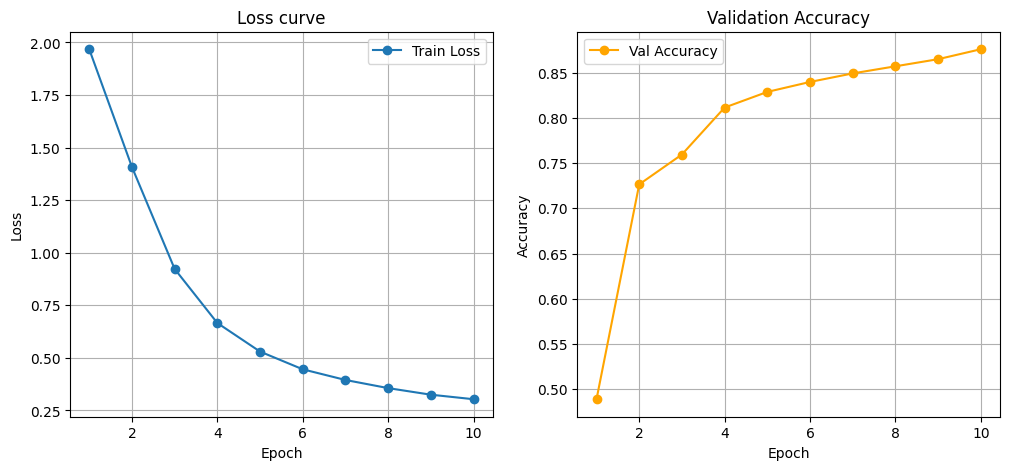

training MLP ended


In [14]:
# -------------------------
# Entraînement MLP
# -------------------------
train_model(mlp_model, MLP_train_loader, MLP_val_loader, num_epochs=10)
print("training MLP ended")

# mlp_model.load(saved_MLP_model_path)

## Résultats et Test du MLP

torch.Size([637]) torch.Size([637])
[MLP] Test Accuracy: 0.882


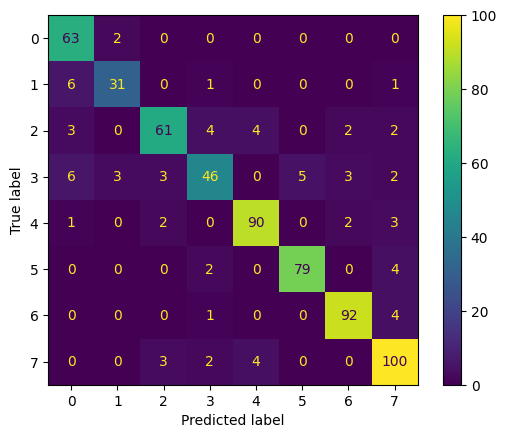

In [15]:
mlp_test_acc, mlp_test_preds, test_labels = evaluate_MLP(mlp_model, MLP_test_loader)
print(mlp_test_preds.shape, test_labels.shape)
print(f"[MLP] Test Accuracy: {mlp_test_acc:.3f}")

# Confusion matrix
disp_CM = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(test_labels, mlp_test_preds, labels=labels),display_labels=labels)
disp_CM.plot()

## Sauvegarde du MLP

In [16]:
mlp_model.save(saved_MLP_model_path)

## Chargement des differents sets pour le transformer et association des enregistrements à leur label
### ⚠️ Attention pas exactement le meme set que le MLP, les deux sont aléatoires.

In [17]:
train_files = torch.load(train_transformer_path)
val_files = torch.load(val_transformer_path)
test_files = torch.load(test_transformer_path)

X_train, y_train = load_split(train_files, embedding_path, is_transformer=True)
X_val, y_val = load_split(val_files, embedding_path, is_transformer=True)
X_test, y_test = load_split(test_files, embedding_path, is_transformer=True)

file_name : YAF_mill_angry.pt, label : 4
file_name : 03-01-08-01-01-01-23.pt, label : 7
file_name : OAF_sail_fear.pt, label : 5
file_name : YAF_loaf_fear.pt, label : 5
file_name : OAF_voice_ps.pt, label : 7
file_name : 03-01-08-01-01-01-14.pt, label : 7
file_name : 03-01-01-01-02-02-23.pt, label : 0
file_name : YAF_home_happy.pt, label : 2
file_name : 03-01-08-02-02-01-03.pt, label : 7
file_name : 03-01-02-02-02-02-11.pt, label : 1
file_name : YAF_jug_sad.pt, label : 3
file_name : YAF_raise_angry.pt, label : 4
file_name : OAF_doll_angry.pt, label : 4
file_name : OAF_sure_ps.pt, label : 7
file_name : OAF_tell_neutral.pt, label : 0
file_name : YAF_phone_neutral.pt, label : 0
file_name : 03-01-07-01-02-01-22.pt, label : 6
file_name : YAF_hurl_happy.pt, label : 2
file_name : YAF_rough_fear.pt, label : 5
file_name : 03-01-06-01-01-01-08.pt, label : 5
file_name : YAF_hire_ps.pt, label : 7
file_name : OAF_ditch_ps.pt, label : 7
file_name : YAF_kick_happy.pt, label : 2
file_name : YAF_gap_disg

## Verification des dimentions des differents sets

In [18]:
print(f"[TRANSFORMER] Loaded splits:")
print("Train :", X_train.shape, y_train.shape)
print("Val   :", X_val.shape, y_val.shape)
print("Test  :", X_test.shape, y_test.shape)

transformer_train_loader = DataLoader(PadDataset(X_train, y_train), batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
transformer_val_loader = DataLoader(PadDataset(X_val, y_val), batch_size=batch_size, collate_fn=collate_fn)
transformer_test_loader = DataLoader(PadDataset(X_test, y_test), batch_size=batch_size, collate_fn=collate_fn)

[TRANSFORMER] Loaded splits:
Train : torch.Size([2968, 264, 1024]) torch.Size([2968])
Val   : torch.Size([636, 239, 1024]) torch.Size([636])
Test  : torch.Size([636, 256, 1024]) torch.Size([636])


## Creation du transformer

In [19]:
input_dim = X_train.shape[2]
transformer_model = TransformerClassifier(input_dim, num_classes).to(device)

## Entrainement du transformer
Attention un peu chronophage...

/Users/alves/These/code/Recent_emo_detection/.venv/lib/python3.9/site-packages/torch/nn/modules/transformer.py:515: UserWarning: The PyTorch API of nested tensors is in prototype stage and will change in the near future. We recommend specifying layout=torch.jagged when constructing a nested tensor, as this layout receives active development, has better operator coverage, and works with torch.compile. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/NestedTensorImpl.cpp:182.)
  output = torch._nested_tensor_from_mask(


[TRANSFORMER] Epoch 1/10 | Train Loss: 1.7789 | Train Acc: 0.304 | Val Acc: 0.464
[TRANSFORMER] Epoch 2/10 | Train Loss: 0.9763 | Train Acc: 0.652 | Val Acc: 0.753
[TRANSFORMER] Epoch 3/10 | Train Loss: 0.5805 | Train Acc: 0.800 | Val Acc: 0.843
[TRANSFORMER] Epoch 4/10 | Train Loss: 0.3983 | Train Acc: 0.863 | Val Acc: 0.871
[TRANSFORMER] Epoch 5/10 | Train Loss: 0.3184 | Train Acc: 0.888 | Val Acc: 0.899
[TRANSFORMER] Epoch 6/10 | Train Loss: 0.2591 | Train Acc: 0.916 | Val Acc: 0.888
[TRANSFORMER] Epoch 7/10 | Train Loss: 0.2293 | Train Acc: 0.920 | Val Acc: 0.888
[TRANSFORMER] Epoch 8/10 | Train Loss: 0.1948 | Train Acc: 0.936 | Val Acc: 0.906
[TRANSFORMER] Epoch 9/10 | Train Loss: 0.1665 | Train Acc: 0.941 | Val Acc: 0.890
[TRANSFORMER] Epoch 10/10 | Train Loss: 0.1571 | Train Acc: 0.944 | Val Acc: 0.904


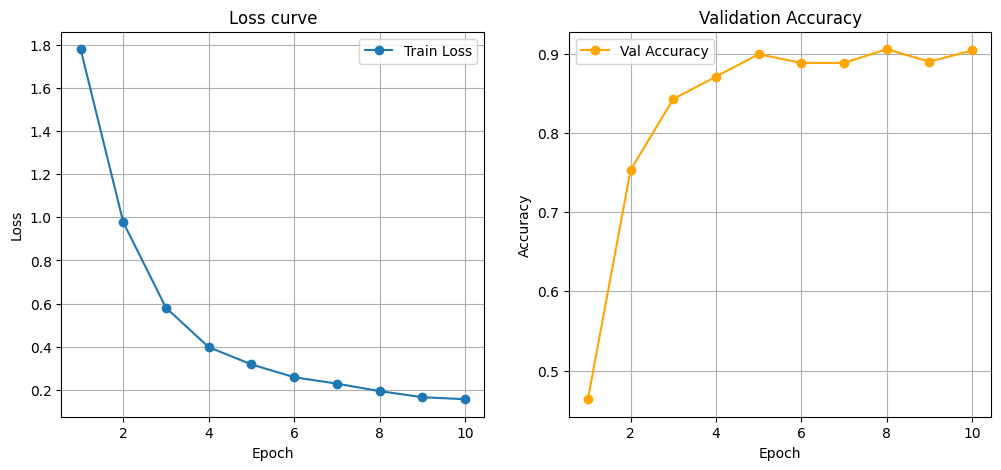

training transformer ended


In [20]:
# -------------------------
# Entraînement Transformer
# -------------------------

train_model(transformer_model, transformer_train_loader, transformer_val_loader,have_mask=True, model_name='transformer', num_epochs=10)
print("training transformer ended")

# transformer_model.load(save_transformer_model_path)

## Résultats et Test du transformer

torch.Size([636]) torch.Size([636])
[Transformer] Test Accuracy: 0.906


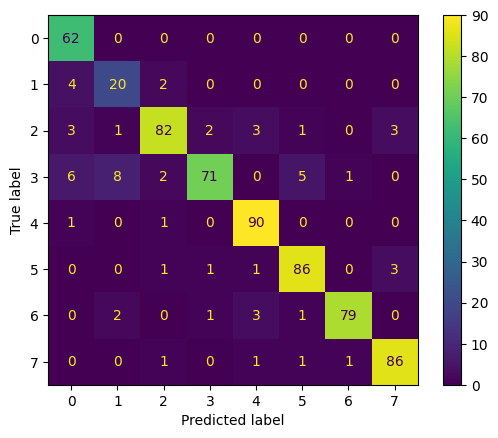

In [21]:
transformer_test_acc, transformer_test_preds, test_labels = evaluate_transformer(transformer_model, transformer_test_loader)
print(transformer_test_preds.shape, test_labels.shape)
print(f"[Transformer] Test Accuracy: {transformer_test_acc:.3f}")

# Confusion matrix
disp_CM = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(test_labels, transformer_test_preds, labels=labels),display_labels=labels)
disp_CM.plot()

## Sauvegarde du transformer

In [22]:
# Save the models
transformer_model.save(saved_transformer_model_path)